In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from os.path import join
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [2]:
data = pd.read_csv(join('..', 'data', 'train.csv'))
data.head(5)

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


> Что ж, не зря же я на пайтоне домашку по eda делала... 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

,mode,Counts,Frequency
0,1,11459,0.637
1,0,6537,0.363


,time_signature,Counts,Frequency
0,4,16451,0.914
1,3,1228,0.068
2,5,203,0.011
3,1,114,0.006



Statictics for numeric variables:


,Popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,Class
mean,44.512,0.543,0.663,5.952,-7.911,0.080,0.247,0.178,0.196,0.486,122.623,"200,744.459",6.696
std,17.427,0.166,0.235,3.197,4.049,0.084,0.311,0.304,0.159,0.240,29.572,"111,989.127",3.206
min,1.000,0.060,0.000,1.000,-39.952,0.022,0.000,0.000,0.012,0.018,30.557,0.502,0.000
25%,33.000,0.432,0.509,3.000,-9.538,0.035,0.004,0.000,0.098,0.297,99.621,"166,337.000",5.000
median,44.000,0.545,0.700,6.000,-7.016,0.047,0.081,0.004,0.129,0.481,120.066,"209,160.000",8.000
75%,56.000,0.659,0.860,9.000,-5.189,0.083,0.434,0.200,0.258,0.672,141.969,"252,490.000",10.000
max,100.000,0.989,1.000,11.000,1.355,0.955,0.996,0.996,1.000,0.986,217.416,"1,477,187.000",10.000
outliers count,41.000,31.000,0.000,0.000,818.000,"2,034.000",0.000,"2,408.000",956.000,0.000,36.000,"3,245.000",0.000



Total 6819 missing values in 17996 rows
Next columns contain missing values:
	 Popularity key instrumentalness
Count of duplicated rows: 0



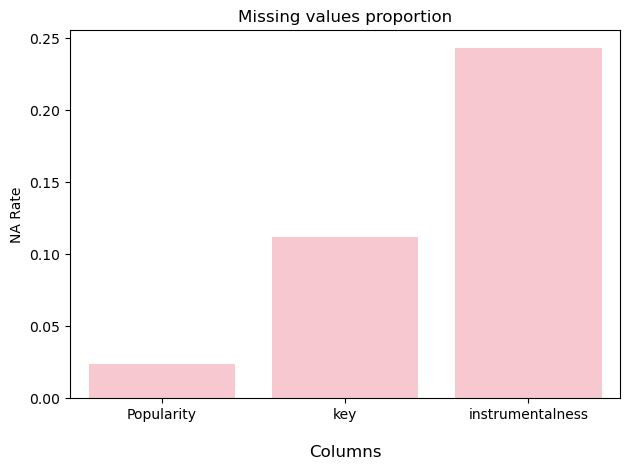

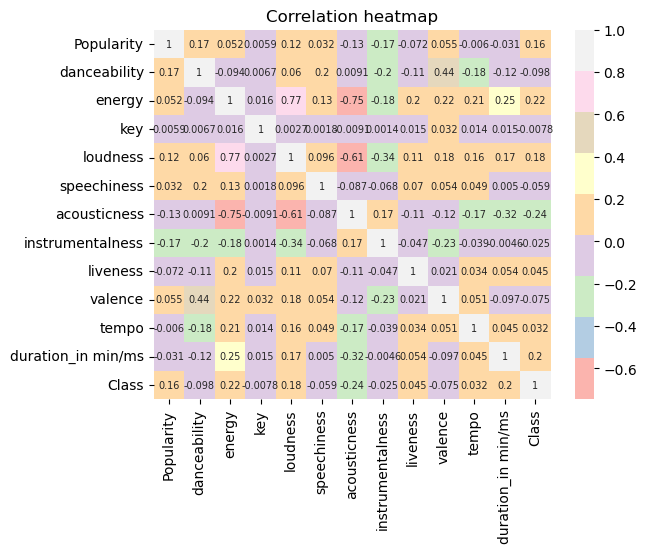

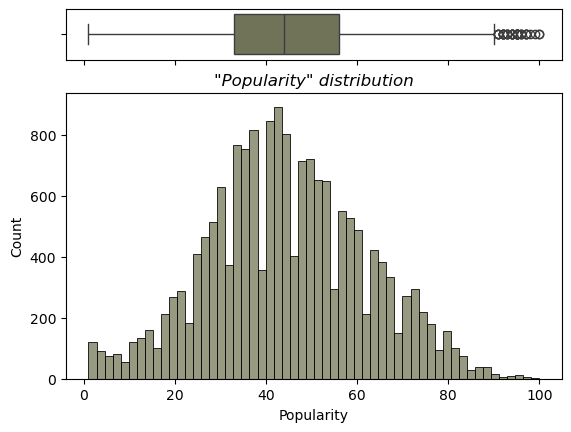

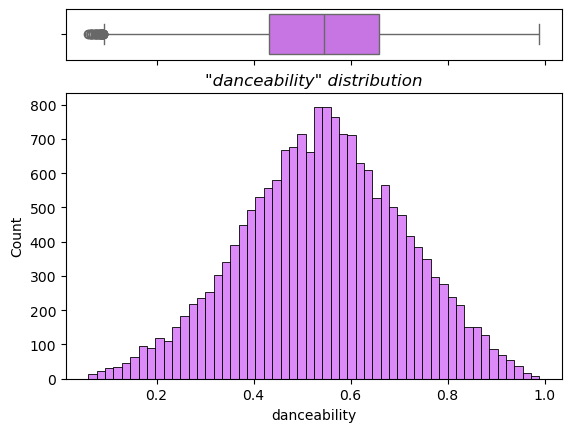

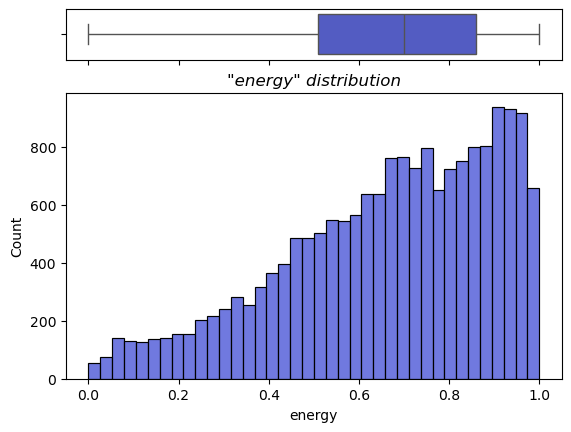

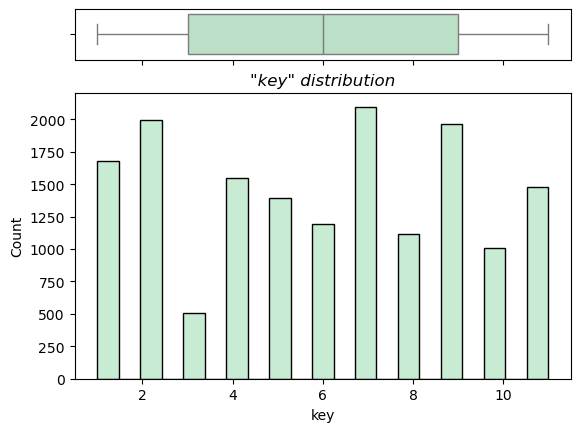

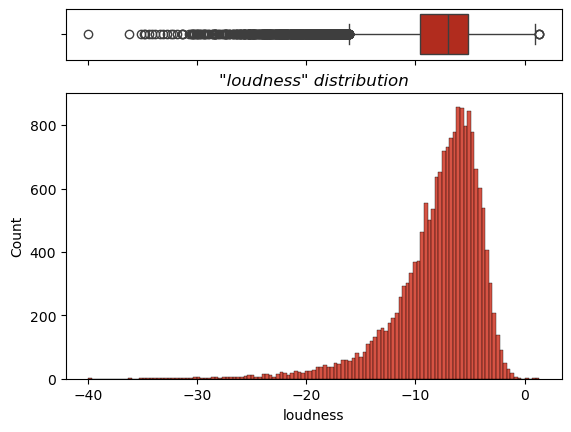

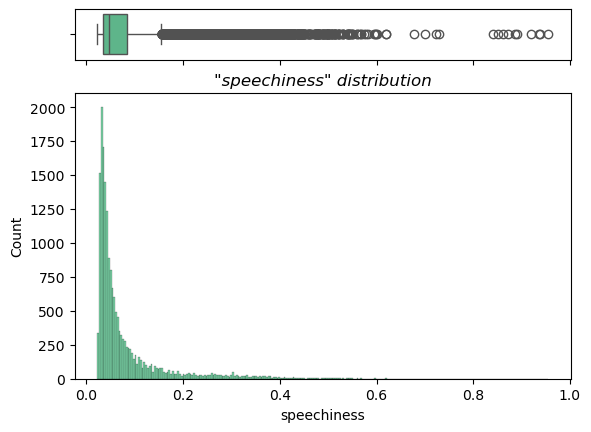

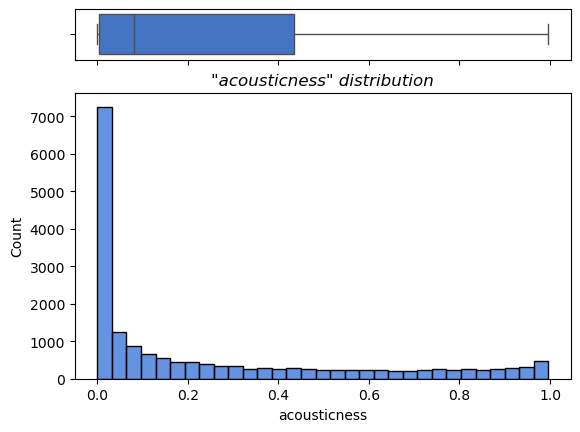

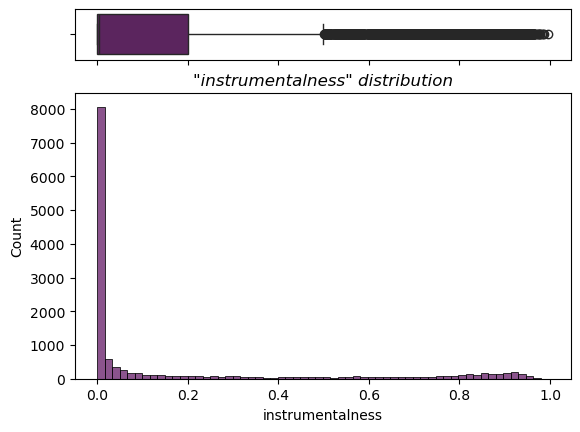

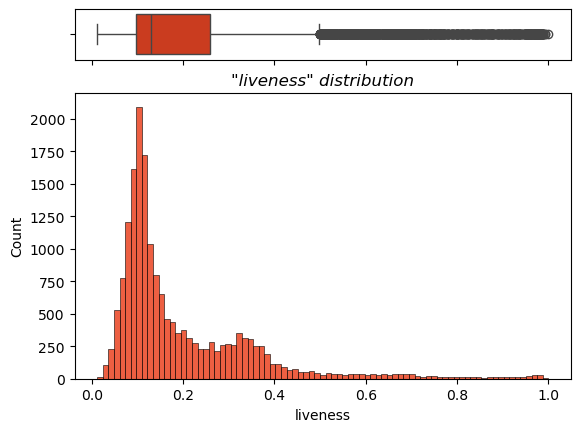

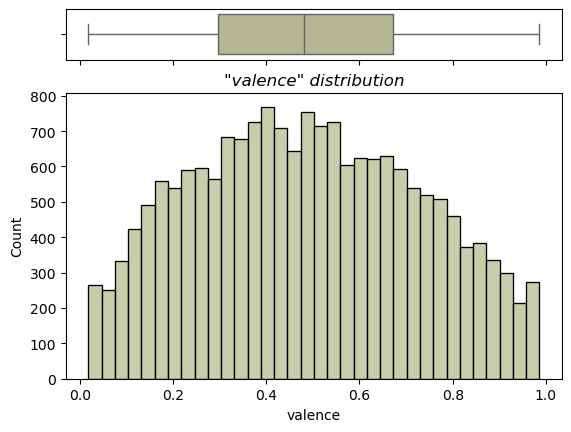

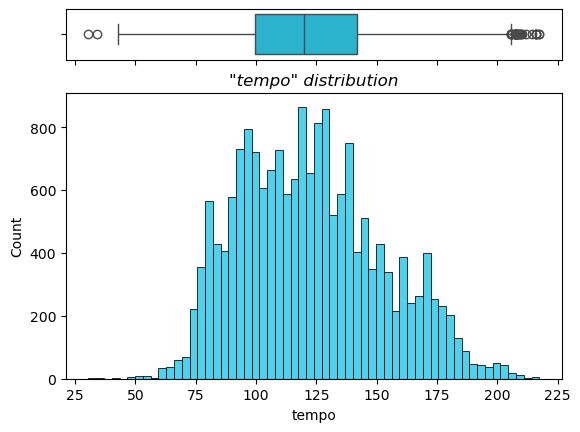

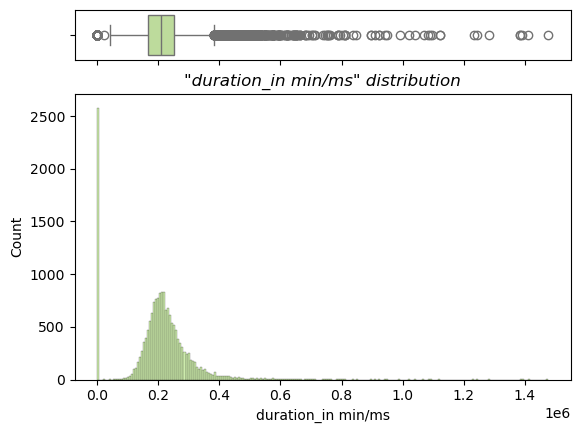

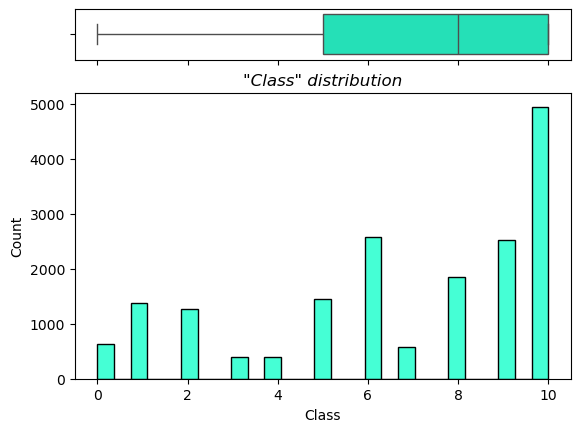

In [3]:
from my_awesome_eda import run_eda

data.info()
run_eda(data)

In [4]:
data['Artist Name'].value_counts()

Artist Name
Backstreet Boys    69
Westlife           60
Britney Spears     54
Omer Adam          48
Eyal Golan         48
                   ..
Rocky Trail         1
Smerz               1
lavender            1
Fear Culture        1
Beherit             1
Name: count, Length: 9149, dtype: int64

<Axes: xlabel='instrumentalness', ylabel='Count'>

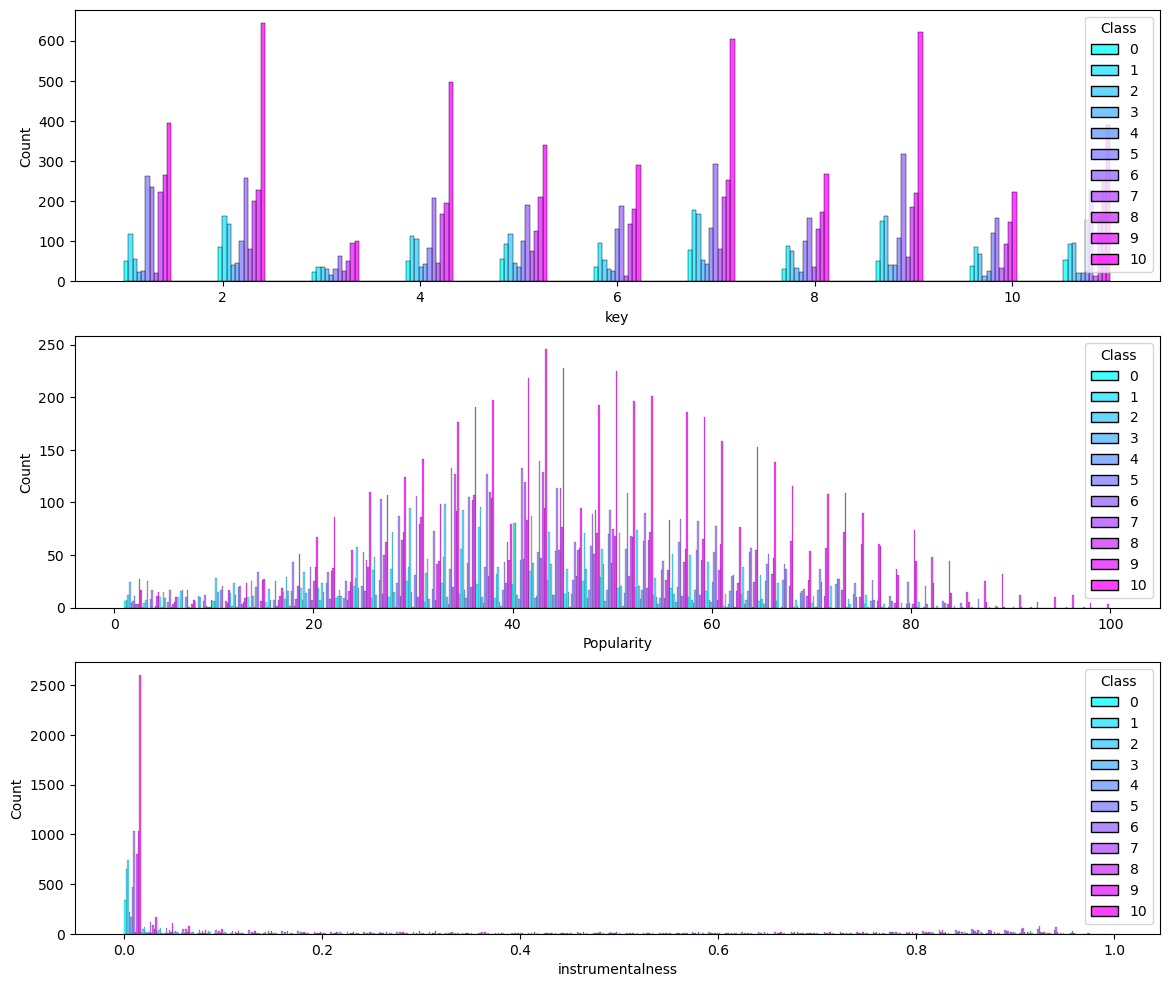

In [5]:
fig, ax = plt.subplots(3,1,figsize=(14,12))

sns.histplot(data=data, x="key", hue="Class", palette='cool', ax=ax[0], multiple='dodge')
sns.histplot(data=data, x="Popularity", hue="Class", palette='cool', ax=ax[1], multiple='dodge')
sns.histplot(data=data, x="instrumentalness", hue="Class", palette='cool', ax=ax[2], multiple='dodge')

> Выводы следующие:
>
> - распределения признаков в целом выглядят как будто бы неплохо. Местами много нулей.
> - `duration_in min/ms` привести к единому виду, что-то типа `duration_in min`
> - признаки, значения которых находятся в диапазоне [0, 1] - не трогать. Измерены они так или уже нормированы - непонятно. Остальные фичи шакалировать
> - признак `Track Name` как будто бы стоит выкинуть. `Artist Name` - перекодировать в категориальный (ибо исполнители соотносятся с жанром музыки, по идее). Почти 10к категорий - пффф
> - NAшки заполнить средним по признаку. Судя по жутковатым графикам чуть выше, распределения признаков с NA по классам аналогичны распределению собственно классов, по идее сильного смещения при замене NA на среднее не привнесется

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

#### Data preprocessing

In [6]:
# приводим duration_in min/ms к единообразию и гармонии:

data.loc[data['duration_in min/ms'] > 10000, 'duration_in min/ms'] /= (1000 * 60)
data.rename(columns={'duration_in min/ms': 'duration_in min'}, inplace=True)

In [7]:
le = LabelEncoder()

data['Artist Name'] = le.fit_transform(data['Artist Name'])

data.drop(columns=['Track Name'], inplace = True)

In [8]:
# split to test and train:

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=111)

In [9]:
preprocessor = ColumnTransformer(transformers = [
    ('imp_num', SimpleImputer(strategy="mean"), ['Popularity', 'instrumentalness']),
    ('imp_cat', SimpleImputer(strategy='most_frequent'), ['key']),
    ('scaler', StandardScaler(), ['Popularity', 'loudness', 'tempo', 'duration_in min'])
])

pipe = Pipeline(steps = [
    ('preprocessor', preprocessor), 
    ('dt', DecisionTreeClassifier())
])

In [11]:
from sklearn.model_selection import GridSearchCV

# сетка гиперпараметров для перебора:
param_grid = {
    'dt__max_depth': [3, 5, 7, 10, 12, 14],
    'dt__min_samples_split': [2, 5, 10, 20],
    'dt__min_samples_leaf': [1, 2, 4, 8, 15]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=8)

# обучение
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

# Получение лучшей модели
best_dt = grid_search.best_estimator_

# Оценка на тестовых данных
test_accuracy = best_dt.score(X_test, y_test)
print("Accuracy for test data:", test_accuracy)

Best params: {'dt__max_depth': 7, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 5}
Best accuracy: 0.3322210695319255
Accuracy for test data: 0.35674594354300954


> В общем, я сделала как будто бы все что могла:
> - со шкалированием и без
> - включая только `Artist Name`, `Artist Name` and `Track Name`, без этих переменных вообще
> - удаляя поочередно переменные с аутокорреляциями (типа `loudness`, `acousticness`)
>
> Каждый запуск GridSearch подбирал разные значения `min_samples_leaf` и `min_samples_split`, однако `max_depth'=7` воспроизводилось стабильно.
>
> Метрикой изначально выбрала accuracy, тк тут как будто бы более объективно будет смотреть на то, угадывает ли модель вообще и что она может выдать в целом. FP и FN, которые учитывает f1, могут занизить значение метрики для данной модели. По факту же посмотрела их оба, значения accuracy и f1 были оч близки.
>
> Да, значение accuracy=0.35 - такое себе. Но и как бы музыкальные сервисы предсказания так себе делают до сих пор... И из имеющихся данных было ожидаемо что-то такое получить

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

> желание есть, но науч и так уже грозится из меня чучело сделать, ибо сильно торможу по научке своей. Прошу понять и простить 🥲

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. Гарфилд (фильм, 2004) - фильм моего детства. Я его настолько много смотрела, что оч актуальна история про "хочется стереть себе память и посмотреть снова"

2. К истории из пункта выше - Шрек, первые две части. Повзрослев полюбила этот мульт еще больше, тк сюжет и образы реалистичны, без навязанных идеалов диснеевских принцесс.

3. Корпорация «Заговор» (2021) - нетфликсовский мультсериал с местами отвратительным (и поэтому прекрасным) юмором 18+